# **Sathmi**- MobileNetV2 (transfer + stronger augmentation)

In [1]:
# Check GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Basic deps for the split script + training
!pip -q install pandas scikit-learn tqdm

In [4]:
#1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
#2) Define paths to your files in root of My Drive and copy to fast local SSD
# Paths on Drive (root)
ZIP1 = "/content/drive/MyDrive/HAM10000_images_part_1.zip"
ZIP2 = "/content/drive/MyDrive/HAM10000_images_part_2.zip"
META = "/content/drive/MyDrive/HAM10000_metadata.csv"

# Local working area on Colab SSD
WORK     = "/content/work"
RAW_DIR  = f"{WORK}/raw"
EXTRACT  = f"{WORK}/ham10000_extracted"
DATA_DIR = f"{WORK}/data"

import os, subprocess, pathlib
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(EXTRACT, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Copy only if missing (fast on later sessions)
print(subprocess.getoutput(f'rsync -ah --ignore-existing "{ZIP1}" "{ZIP2}" "{META}" "{RAW_DIR}/"'))
print("Local RAW_DIR:", subprocess.getoutput(f'ls -lh "{RAW_DIR}"'))


Local RAW_DIR: total 2.6G
-rw------- 1 root root 1.3G Oct 11 10:06 HAM10000_images_part_1.zip
-rw------- 1 root root 1.4G Oct 11 10:07 HAM10000_images_part_2.zip
-rw------- 1 root root 551K Oct 11 09:09 HAM10000_metadata.csv


In [6]:
import os, json, time, argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [7]:
!mkdir -p /content/scripts

In [8]:
%%writefile /content/scripts/split_ham10000.py
#!/usr/bin/env python3
import argparse, os, shutil, zipfile
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def unzip_if_needed(zip_path: Path, extract_dir: Path):
    extract_dir.mkdir(parents=True, exist_ok=True)
    # If any jpgs already exist anywhere under extract_dir, skip
    if any(extract_dir.rglob("*.jpg")):
        print(f"[skip] Images already present under: {extract_dir}")
        return
    assert zip_path.exists(), f"Missing: {zip_path}"
    print(f"[unzip] {zip_path.name} -> {extract_dir}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)

def index_images(img_root: Path):
    """
    Build a dict: image_id (without .jpg) -> full path
    Recurses under img_root to handle both 'HAM10000_images' and '..._part_1/part_2' layouts.
    """
    mapping = {}
    for p in img_root.rglob("*.jpg"):
        mapping[p.stem] = str(p)
    return mapping

def build_splits(meta_csv: Path, img_root: Path, train_pct: float, val_pct: float, test_pct: float, seed: int):
    assert abs((train_pct + val_pct + test_pct) - 1.0) < 1e-6, "Splits must sum to 1.0"
    meta = pd.read_csv(meta_csv)
    img_map = index_images(img_root)
    meta["image_path"] = meta["image_id"].map(img_map)
    meta = meta.dropna(subset=["image_path"]).copy()

    # quick sanity
    print(f"[info] Found {len(img_map)} jpgs under {img_root}")
    print(f"[info] Matched rows with metadata: {len(meta)}")

    train_df, temp_df = train_test_split(
        meta, test_size=1.0-train_pct, stratify=meta["dx"], random_state=seed
    )
    test_rel = test_pct / (val_pct + test_pct)
    val_df, test_df = train_test_split(
        temp_df, test_size=test_rel, stratify=temp_df["dx"], random_state=seed
    )
    return train_df, val_df, test_df, sorted(meta["dx"].unique())

def materialize_split(df: pd.DataFrame, split_name: str, out_root: Path):
    base = out_root / split_name
    base.mkdir(parents=True, exist_ok=True)
    for cls in sorted(df["dx"].unique()):
        (base / cls).mkdir(parents=True, exist_ok=True)
    for _, r in tqdm(df.iterrows(), total=len(df), desc=f"{split_name:>5}", unit="img"):
        src = Path(r["image_path"])
        dst = base / r["dx"] / src.name
        if not dst.exists():
            shutil.copy2(src, dst)

def print_counts(data_dir: Path):
    for split in ["train", "val", "test"]:
        base = data_dir / split
        if base.exists():
            counts = {
                d.name: len(list((base / d).glob("*")))
                for d in base.iterdir() if d.is_dir()
            }
            print(split, counts)

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--project_dir", default=".")
    p.add_argument("--train", type=float, default=0.8)
    p.add_argument("--val",   type=float, default=0.1)
    p.add_argument("--test",  type=float, default=0.1)
    p.add_argument("--seed",  type=int, default=42)
    p.add_argument("--clean", action="store_true")
    args = p.parse_args()

    project = Path(args.project_dir).resolve()
    raw_dir  = project / "raw"
    data_dir = project / "data"
    extract  = project / "ham10000_extracted"   # we recurse under this folder
    imgs_root = extract                         # <-- recursive root

    part1 = raw_dir / "HAM10000_images_part_1.zip"
    part2 = raw_dir / "HAM10000_images_part_2.zip"
    meta  = raw_dir / "HAM10000_metadata.csv"

    extract.mkdir(parents=True, exist_ok=True)
    data_dir.mkdir(parents=True, exist_ok=True)

    unzip_if_needed(part1, extract)
    unzip_if_needed(part2, extract)

    train_df, val_df, test_df, classes = build_splits(
        meta, imgs_root, args.train, args.val, args.test, args.seed
    )

    if args.clean:
        for s in ["train", "val", "test"]:
            target = data_dir / s
            if target.exists():
                shutil.rmtree(target)

    materialize_split(train_df, "train", data_dir)
    materialize_split(val_df, "val", data_dir)
    materialize_split(test_df, "test", data_dir)
    print_counts(data_dir)
    print("[done] Data ready at:", data_dir)

if __name__ == "__main__":
    main()

Writing /content/scripts/split_ham10000.py


In [9]:
!python /content/scripts/split_ham10000.py \
  --project_dir "/content/work" \
  --train 0.8 --val 0.1 --test 0.1 --seed 42 --clean

[unzip] HAM10000_images_part_1.zip -> /content/work/ham10000_extracted
[skip] Images already present under: /content/work/ham10000_extracted
[info] Found 5000 jpgs under /content/work/ham10000_extracted
[info] Matched rows with metadata: 5000
train: 100% 4000/4000 [00:03<00:00, 1008.34img/s]
  val: 100% 500/500 [00:00<00:00, 915.05img/s]
 test: 100% 500/500 [00:00<00:00, 924.71img/s]
train {'vasc': 52, 'mel': 348, 'akiec': 146, 'nv': 2745, 'bcc': 213, 'bkl': 451, 'df': 45}
val {'vasc': 7, 'mel': 43, 'akiec': 19, 'nv': 343, 'bcc': 27, 'bkl': 56, 'df': 5}
test {'vasc': 6, 'mel': 44, 'akiec': 18, 'nv': 343, 'bcc': 26, 'bkl': 57, 'df': 6}
[done] Data ready at: /content/work/data


In [10]:
#Quick sanity check:
import os
for split in ("train","val","test"):
    base = os.path.join("/content/work/data", split)
    classes = [d for d in sorted(os.listdir(base)) if os.path.isdir(os.path.join(base,d))]
    counts = {c: len(os.listdir(os.path.join(base,c))) for c in classes}
    print(split, counts)

train {'akiec': 146, 'bcc': 213, 'bkl': 451, 'df': 45, 'mel': 348, 'nv': 2745, 'vasc': 52}
val {'akiec': 19, 'bcc': 27, 'bkl': 56, 'df': 5, 'mel': 43, 'nv': 343, 'vasc': 7}
test {'akiec': 18, 'bcc': 26, 'bkl': 57, 'df': 6, 'mel': 44, 'nv': 343, 'vasc': 6}


In [11]:
import os
print("Exists:", os.path.isdir("/content/work/data"))
print("Splits:", os.listdir("/content/work/data"))

Exists: True
Splits: ['val', 'train', 'test']


In [12]:
# make sure the folder exists
!mkdir -p /content/members

In [13]:
%%writefile /content/members/run_mobilenetv2.py
#!/usr/bin/env python3
import os, json, time, argparse, csv, datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

MODEL_DIR = "mobilenetv2"  # model-specific folder & master CSV

def get_datasets(data_dir, img_size=(224,224), batch=32, seed=42, binary=False):
    def loader(split, shuffle):
        return tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_dir, split),
            image_size=img_size, batch_size=batch, seed=seed, shuffle=shuffle
        )
    ds_train = loader("train", True)
    ds_val   = loader("val",   False)
    ds_test  = loader("test",  False)
    class_names = ds_train.class_names

    # stronger augmentation (MobileNetV2 tolerates it well)
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.15),
    ])
    ds_train = ds_train.map(lambda x,y: (aug(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache().prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.cache().prefetch(tf.data.AUTOTUNE)
    ds_test  = ds_test.cache().prefetch(tf.data.AUTOTUNE)
    return ds_train, ds_val, ds_test, class_names, bool(binary)

def compute_class_weights(ds, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    tot = counts.sum()
    return {i: float(tot / (n_classes * max(counts[i], 1))) for i in range(n_classes)}

def build_model(num_classes, img_size=(224,224), binary=False):
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
    inp = keras.Input(shape=(*img_size, 3))
    x = preprocess_input(inp)
    base = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x) if binary \
          else layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return keras.Model(inp, out), base

def compile_and_fit(model, train_ds, val_ds, *, loss, lr, epochs, class_weight, ckpt_path):
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=loss, metrics=["accuracy"])
    os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
    cbs = [
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True,
                                        monitor="val_accuracy", mode="max"),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                      monitor="val_accuracy", mode="max"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3,
                                          patience=2, min_lr=1e-6, verbose=1),
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                     class_weight=class_weight, callbacks=cbs)
    return {k: [float(v) for v in vals] for k, vals in hist.history.items()}

def eval_save(model, ds_test, names, out_dir, binary=False):
    y_true, y_pred = [], []
    for x, y in ds_test:
        p = model.predict(x, verbose=0)
        yp = (p.reshape(-1) >= 0.5).astype(int) if binary else p.argmax(axis=1)
        y_true += y.numpy().tolist(); y_pred += yp.tolist()
    y_true = np.array(y_true); y_pred = np.array(y_pred)

    acc = float(accuracy_score(y_true, y_pred))
    f1  = float(f1_score(y_true, y_pred, average=("binary" if binary else "macro")))
    rep = classification_report(y_true, y_pred, target_names=names)
    cm  = confusion_matrix(y_true, y_pred).tolist()

    os.makedirs(out_dir, exist_ok=True)
    json.dump({"accuracy": acc, "macro_f1": f1, "confusion_matrix": cm},
              open(os.path.join(out_dir, "metrics.json"), "w"), indent=2)
    open(os.path.join(out_dir, "classification_report.txt"), "w").write(rep)
    json.dump(names, open(os.path.join(out_dir, "classes.json"), "w"), indent=2)
    print(rep); print("Saved:", out_dir)
    return acc, f1

def write_epoch_csv(history, path_csv):
    import pandas as pd
    n = max(len(history.get("accuracy",[])), len(history.get("loss",[])))
    rows = [{
        "epoch": i+1,
        "accuracy": history.get("accuracy",[None]*n)[i],
        "loss": history.get("loss",[None]*n)[i],
        "val_accuracy": history.get("val_accuracy",[None]*n)[i],
        "val_loss": history.get("val_loss",[None]*n)[i],
    } for i in range(n)]
    pd.DataFrame(rows).to_csv(path_csv, index=False)

def append_master_row(master_csv, row):
    headers = ["timestamp","run_name","data","img_size","batch","warmup","epochs",
               "unfreeze","base_lr","ft_lr","binary","best_val_acc","best_val_loss",
               "test_acc","test_macro_f1"]
    os.makedirs(os.path.dirname(master_csv), exist_ok=True)
    new = not os.path.isfile(master_csv)
    with open(master_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=headers)
        if new: w.writeheader()
        w.writerow({k: row.get(k) for k in headers})

def main(a):
    run = a.run_name or time.strftime("%Y%m%d-%H%M%S")
    out_root = a.out_dir or "runs"
    model_root = os.path.join(out_root, MODEL_DIR)
    out = os.path.join(model_root, run)
    os.makedirs(out, exist_ok=True)

    ds_tr, ds_va, ds_te, names, binary = get_datasets(a.data, (a.size, a.size), a.batch, binary=bool(a.binary))
    ncls = 2 if binary else len(names)
    class_weight = compute_class_weights(ds_tr, ncls)

    model, base = build_model(ncls, (a.size, a.size), binary)
    loss = "binary_crossentropy" if binary else keras.losses.SparseCategoricalCrossentropy()

    # Phase 1: warmup (base frozen)
    base.trainable = False
    hist_warm = compile_and_fit(model, ds_tr, ds_va, loss=loss, lr=a.base_lr,
                                epochs=max(1, a.warmup), class_weight=class_weight,
                                ckpt_path=os.path.join(out, "best.keras"))

    # Phase 2: fine-tune (partial unfreeze)
    base.trainable = True
    if a.unfreeze > 0 and a.unfreeze < len(base.layers):
        for l in base.layers[:-a.unfreeze]:
            l.trainable = False
    hist_ft = compile_and_fit(model, ds_tr, ds_va, loss=loss, lr=a.ft_lr,
                              epochs=a.epochs, class_weight=class_weight,
                              ckpt_path=os.path.join(out, "best.keras"))

    # Save histories
    history = {}
    for k in set(list(hist_warm.keys()) + list(hist_ft.keys())):
        history[k] = (hist_warm.get(k, []) + hist_ft.get(k, []))
    json.dump(history, open(os.path.join(out,"history.json"),"w"), indent=2)
    write_epoch_csv(history, os.path.join(out,"history_epoch.csv"))

    # Evaluate & save reports
    test_acc, test_f1 = eval_save(model, ds_te, names, out, binary)

    # Model-specific master CSV
    best_idx = int(np.nanargmax(history.get("val_accuracy", [np.nan])))
    best_val_acc  = float(history["val_accuracy"][best_idx]) if "val_accuracy" in history else None
    best_val_loss = float(history["val_loss"][best_idx]) if "val_loss" in history else None
    master_csv = os.path.join(model_root, "experiments_master.csv")
    append_master_row(master_csv, {
        "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
        "run_name": run,
        "data": a.data, "img_size": a.size, "batch": a.batch,
        "warmup": a.warmup, "epochs": a.epochs, "unfreeze": a.unfreeze,
        "base_lr": a.base_lr, "ft_lr": a.ft_lr, "binary": int(a.binary),
        "best_val_acc": best_val_acc, "best_val_loss": best_val_loss,
        "test_acc": test_acc, "test_macro_f1": test_f1
    })
    print(f"[master] Appended summary to: {master_csv}")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    # default so you don't hit the --data error
    ap.add_argument("--data", default=os.environ.get("DATA_DIR", "/content/work/data"))
    ap.add_argument("--epochs", type=int, default=25)     # MBV2 benefits from slightly longer
    ap.add_argument("--warmup", type=int, default=5)
    ap.add_argument("--size", type=int, default=224)
    ap.add_argument("--batch", type=int, default=32)      # you can push to 64 on bigger GPUs
    ap.add_argument("--base_lr", type=float, default=3e-4)
    ap.add_argument("--ft_lr", type=float, default=3e-5)
    ap.add_argument("--unfreeze", type=int, default=40)   # unfreeze tail blocks
    ap.add_argument("--binary", type=int, default=0)
    ap.add_argument("--run_name", default="")
    ap.add_argument("--out_dir", default="runs")
    a = ap.parse_args(); main(a)


Writing /content/members/run_mobilenetv2.py


In [15]:
# baseline (batch 32)
!python /content/members/run_mobilenetv2.py \
  --data "/content/work/data" \
  --epochs 30 --warmup 5 --unfreeze 40 \
  --batch 30 --base_lr 3e-4 --ft_lr 3e-5 \
  --out_dir /content/runs --run_name e25_b32

2025-10-11 18:23:50.512569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760207030.533029    3257 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760207030.539164    3257 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760207030.554840    3257 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760207030.554866    3257 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760207030.554870    3257 computation_placer.cc:177] computation placer alr

In [16]:
# larger batch (if GPU allows)
!python /content/members/run_mobilenetv2.py \
  --data "/content/work/data" \
  --epochs 35 --warmup 5 --unfreeze 40 \
  --batch 64 --base_lr 3e-4 --ft_lr 3e-5 \
  --out_dir /content/runs --run_name e25_b64

2025-10-11 18:29:07.575355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760207347.597429    5219 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760207347.604313    5219 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760207347.621024    5219 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760207347.621052    5219 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760207347.621056    5219 computation_placer.cc:177] computation placer alr

In [17]:
!ls -lah /content/runs/mobilenetv2/e25_b32
!sed -n '1,10p' /content/runs/mobilenetv2/experiments_master.csv

total 23M
drwxr-xr-x 2 root root 4.0K Oct 11 18:23 .
drwxr-xr-x 4 root root 4.0K Oct 11 18:29 ..
-rw-r--r-- 1 root root  23M Oct 11 18:28 best.keras
-rw-r--r-- 1 root root   66 Oct 11 18:28 classes.json
-rw-r--r-- 1 root root  596 Oct 11 18:28 classification_report.txt
-rw-r--r-- 1 root root 2.0K Oct 11 18:28 history_epoch.csv
-rw-r--r-- 1 root root 3.2K Oct 11 18:28 history.json
-rw-r--r-- 1 root root  619 Oct 11 18:28 metrics.json
timestamp,run_name,data,img_size,batch,warmup,epochs,unfreeze,base_lr,ft_lr,binary,best_val_acc,best_val_loss,test_acc,test_macro_f1
2025-10-11T18:23:42,e25_b32,/content/work/data,224,32,5,15,40,0.0003,3e-05,0,0.7620000243186951,0.7243697047233582,0.758,0.5014429049211657
2025-10-11T18:28:49,e25_b32,/content/work/data,224,30,5,30,40,0.0003,3e-05,0,0.7739999890327454,0.7126214504241943,0.772,0.48887221979979384
2025-10-11T18:35:40,e25_b64,/content/work/data,224,64,5,35,40,0.0003,3e-05,0,0.7739999890327454,0.747566819190979,0.76,0.5186618989077004


Loaded data from CSV: 25 epochs


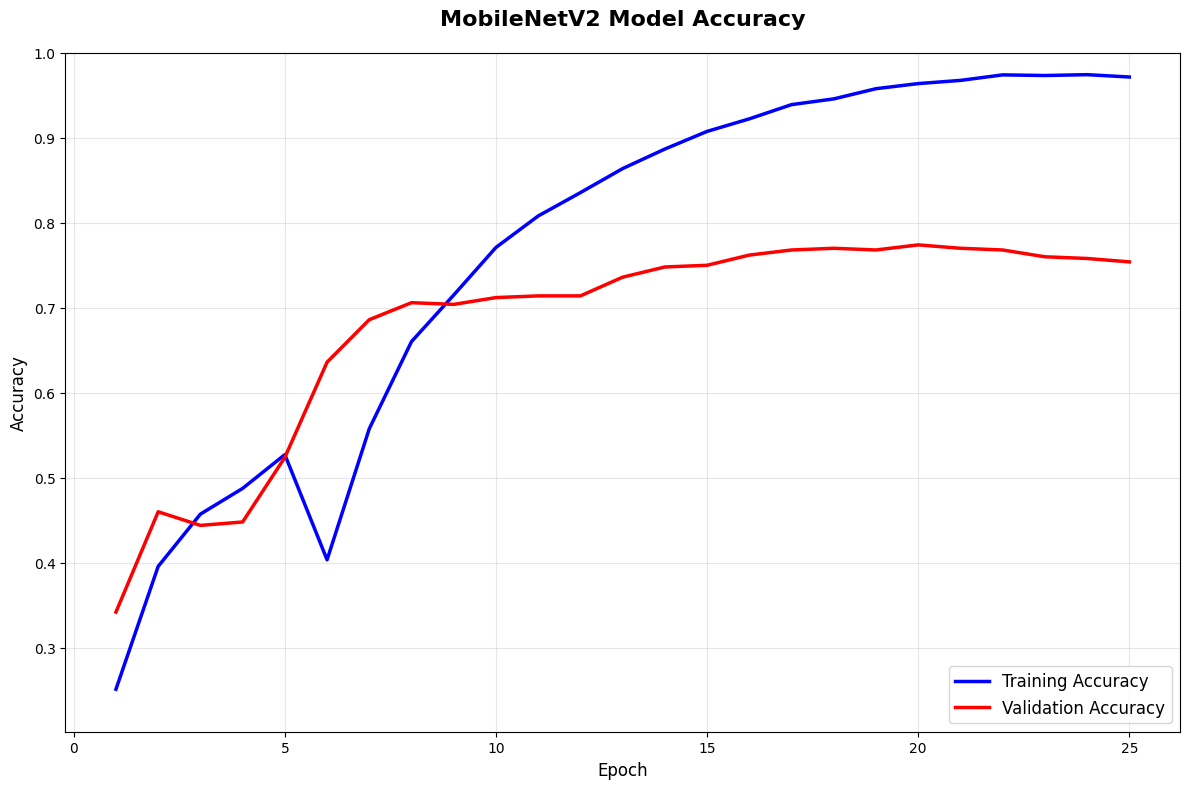

Final Training Accuracy: 0.9715
Final Validation Accuracy: 0.7540
Best Validation Accuracy: 0.7740


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

def plot_accuracy_from_saved_run(run_path):
    """
    Plot accuracy graph from saved MobileNetV2 run
    """
    # Try to load from CSV first
    csv_path = os.path.join(run_path, "history_epoch.csv")
    json_path = os.path.join(run_path, "history.json")

    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        epochs = df['epoch'].values
        train_acc = df['accuracy'].values
        val_acc = df['val_accuracy'].values
        print(f"Loaded data from CSV: {len(epochs)} epochs")
    elif os.path.exists(json_path):
        with open(json_path, 'r') as f:
            history = json.load(f)
        train_acc = history.get('accuracy', [])
        val_acc = history.get('val_accuracy', [])
        epochs = range(1, len(train_acc) + 1)
        print(f"Loaded data from JSON: {len(epochs)} epochs")
    else:
        print("No history file found. Using extracted data from log.")
        return

    # Create the accuracy graph
    plt.figure(figsize=(12, 8))

    # Plot training and validation accuracy
    plt.plot(epochs, train_acc, 'b-', linewidth=2.5, label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', linewidth=2.5, label='Validation Accuracy')

    # Customize the graph
    plt.title('MobileNetV2 Model Accuracy', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=12)

    # Set appropriate limits
    y_min = min(min(train_acc), min(val_acc)) - 0.05
    y_max = max(max(train_acc), max(val_acc)) + 0.05
    plt.ylim(max(0, y_min), min(1.0, y_max))

    # Add grid
    plt.grid(True, alpha=0.3)

    # Improve layout
    plt.tight_layout()

    # Save the plot
    plt.savefig('mobilenetv2_accuracy_graph.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print statistics
    print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Best Validation Accuracy: {max(val_acc):.4f}")

# Use your actual run path
plot_accuracy_from_saved_run('/content/runs/mobilenetv2/e25_b32')

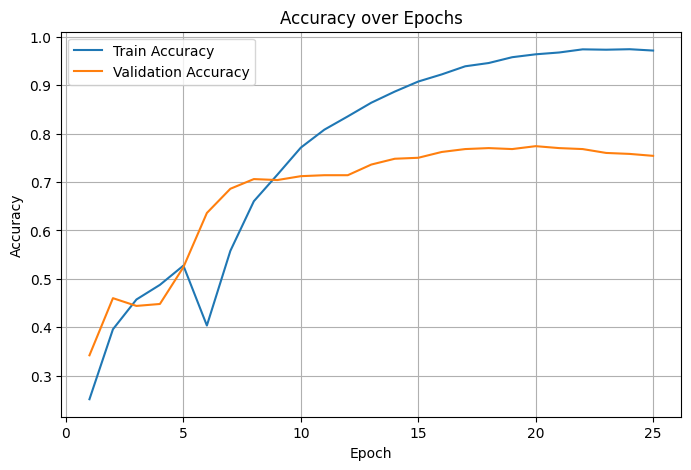

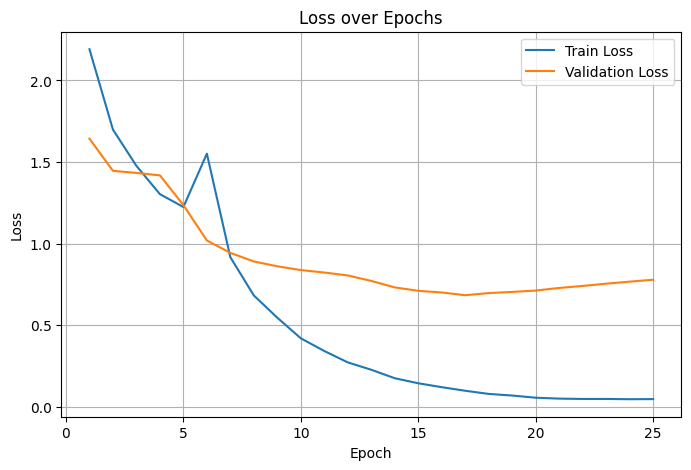

In [29]:
import json
import matplotlib.pyplot as plt

# Load history from the history.json file
with open('/content/runs/mobilenetv2/e25_b32/history.json') as f:
    history = json.load(f)

epochs = range(1, len(history['accuracy'])+1)

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
#Save results back to Drive (persistent)

# Save all runs
!mkdir -p "/content/drive/MyDrive/SKIN_CANCER_RESULTS/MobileNet"
!rsync -ah --info=progress2 "/content/runs/" "/content/drive/MyDrive/SKIN_CANCER_RESULTS/MobileNet"

# Inspect what's saved
!find "/content/drive/MyDrive/SKIN_CANCER_RESULTS" -maxdepth 3 -type f | head -n 20

              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/17)
/content/drive/MyDrive/SKIN_CANCER_RESULTS/MobileNet/mobilenetv2/experiments_master.csv
